In [1]:
import numpy as np
import pandas as pd
# import altair as alt
# from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:
# Game class
class Card:
    def __init__(self, kind, show):
        self.kind = kind
        self.show = show
    def toString(self):
        return '[' + self.show +","+ self.kind +  ']'
        
class Game:
    #attrs
    # DC = ['A', 2, 3, 4, 5, 6, 7, 8, 9, 10] #dealer's cards
    # PS = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21] #player's sum

    #--------------------

    def __init__(self):
        self.deck = self.createDeck()
        random.shuffle(self.deck)
        self.PH = []
        self.DH = []
        self.usefulAce = False
    
    def createDeck(self):
        kinds = ['Diamond', 'Club', 'Spade', 'Heart']
        shows = ['A', '2', '3', '4', '5', '6', '7', '8', '9','T', 'J', 'Q', 'K']
        return [Card(kind, show) for kind in kinds for show in shows]
    
    def newHand(self, target):
        card = self.deck.pop() #no repeat object
        if target == 'Player':
            self.PH.append(card)
        else:
            self.DH.append(card)
    
    def sum(self, target):
        if target == "Player":
            sum = 0
            for card in self.PH:
                if card.show in ('T', 'J', 'Q', 'K'):
                    sum += 10
                elif card.show == 'A':
                    self.usefulAce =True
                    sum += 11
                else:
                    sum += int(card.show)
            
            while sum > 21:
                if self.usefulAce == True:
                    sum -= 10
                    self.usefulAce = False
                else:
                    break
            return sum
        else:
            sum = 0
            for card in self.DH:
                if card.show in ('T','J', 'Q', 'K'):
                    sum += 10
                elif card.show == 'A':
                    sum += 11
                else:
                    sum += int(card.show)
            while sum > 21:
                if 'A' in [c.show for c in self.DH]:
                    sum -= 10
                else:
                    break
            return sum
        
    def displayHand(self, target, showAll=False):
        temp = None
        if target == 'Player': 
            temp = self.PH
            out = ""
            for card in temp:
                out += card.toString() + "/"
            print(out)
        else: #for dealer, only display one single card at the beginning
            temp = self.DH
            skip = 0
            out=""
            if showAll == True:
                for card in temp:
                    out += card.toString() + "/"
                print(out)
            else: 
                for card in temp:
                    if skip != 1:
                        out += card.toString() + "/"
                    else:
                        out += "???" + "/"
                    skip += 1
                print(out)
    
    #工具函数
    def usefulAce(self):
        return self.usefulAce
    
    def dealderFaceUp(self):
        return self.DH[0].show
        
    # def toString(sessions):
    #     temp = "Start: "
    #     for session in sessions:
    #         temp += session.toString + " |---> "
    #     print(temp)
    #     return 0

class Session:
    def __init__(self):
        self.seq = []
        self.game = Game()
        self.stop = False
        self.winner = None
        self.gameTree = ['START'] 
        #'START',....., 'DEALERROUND',....., 'END', winner
        #'START',.....,'END', winner
        # self.gameStatus = None

    # def run(self):
    #     #init
    #     self.game.newHand("Player")
    #     self.game.newHand("Dealer")
    #     self.game.newHand("Player")
    #     self.game.newHand("Dealer")
    #     self.gameTree.append({'Player Cards':(self.game.PH[0], self.game.PH[1]), 'Dealer Cards':(self.game.DH[0], self.game.DH[1])})
        
    #     print("---------------------starter hands------------------------\n")
    #     print("For Player: \n")
    #     self.game.displayHand("Player")
    #     print("For Dealer: \n")
    #     self.game.displayHand("Dealer")

    #     round = 1
    #     #start to hit
    #     while(not self.stop):
    #         print("------------------session {}----------------".format(round))
    #         self.playerTurn()
    #         if self.stop == True: break
    #         self.dealerTurn()
    #         self.stop = True

    #     winner = self.checkWin()
    #     self.winner = winner
    #     print("------------------------------end of the game-----------------------------------\n")
    #     print("The winnder is: " + winner + "\n")
    #     print("For Player: \n")
    #     self.game.displayHand("Player")
    #     print("For Dealer: \n")
    #     self.game.displayHand("Dealer", showAll=True)

    def runAgent(self, Agent):
        #init
        self.game.newHand("Player")
        self.game.newHand("Dealer")
        self.game.newHand("Player")
        self.game.newHand("Dealer")
        self.gameTree.append({'Player Cards':(self.game.PH[0], self.game.PH[1]),
                              'Player Sum': self.game.sum("Player"),
                              'Useful Ace': self.game.usefulAce,
                              'Dealer Face': self.game.dealderFaceUp(),
                              'Result': 'Continue'
                              })

        
        # print("---------------------starter hands------------------------\n")
        # print("For Player: \n")
        # self.game.displayHand("Player")
        # # print("For Dealer: \n")
        # self.game.displayHand("Dealer")
        self.someoneBusted = False
        #start to hit
        while(not self.stop):
            self.playerTurnAgent(Agent)
            if self.stop == True: break
            # print("---------------------------dealer turn-----------------------------------\n")
            self.gameTree.append('DEALDERROUND')
            self.dealerTurn()
            self.stop = True

        if not self.someoneBusted:
            winner = self.checkWin()
            self.winner = winner
            # print("------------------------------end of the game-----------------------------------\n")
            # print("The winnder is: " + winner + "\n")
            # print("For Player: \n")
            # self.game.displayHand("Player")
            # print("For Dealer: \n")
            # self.game.displayHand("Dealer", showAll=True)
        
        self.gameTree.append('END')
        self.gameTree.append(self.winner)
    
    def playerTurnAgent(self, Agent):
        location = (int(self.game.usefulAce), self.game.dealderFaceUp(), self.game.sum("Player"))
        while (True and self.stop == False):
            action = Agent.policy(location) #values: {'h': ,'s': }
            self.gameTree[-1]['Player Action'] = action
            # print("player's action is: " + action)
            if action == 'h':
                self.game.newHand("Player")
                # print("Player's card after action: \n")
                # self.game.displayHand("Player")
                if self.bust("Player"):
                    # print("Player you are busted!!!")
                    # print("------------------------------end of the game-----------------------------------\n")
                    # print("The winnder is: " + "Dealer" + "\n")
                    self.winner = 'Dealer'
                    # print("For Player: \n")
                    # self.game.displayHand("Player")
                    # print("For Dealer: \n")
                    # self.game.displayHand("Dealer", showAll=True)
                    self.needStop()
                    self.someoneBusted = True
                    self.gameTree.append({"Player Cards":self.game.PH, 
                                          'Player Sum': self.game.sum("Player"),
                                          'Useful Ace': self.game.usefulAce,
                                          'Dealer Face': self.game.dealderFaceUp(),
                                          "Result":"Busted"})
                else: #not busted yet
                    # print(self.game.sum("Player"))
                    self.gameTree.append({"Player Cards":self.game.PH, 
                                          'Player Sum': self.game.sum("Player"), 
                                          'Useful Ace': self.game.usefulAce,
                                          'Dealer Face': self.game.dealderFaceUp(),
                                          "Result":"Continue"})
                
            elif action == 's':
                self.gameTree.append({"Player Cards":self.game.PH, 
                                      'Player Sum': self.game.sum("Player"), 
                                      'Useful Ace': self.game.usefulAce,
                                      'Dealer Face': self.game.dealderFaceUp(),
                                      "Result":"End Round"})
                break
            else:
                print("agent gives illegal action.")

    # def playerTurn(self):
    #     while (True and self.stop == False):
    #         action = input("Do you want to (H)it or (S)tand? ").lower()
    #         if action == 'h':
    #             self.game.newHand("Player")
    #             # print("Player's card after action: \n")
    #             self.game.displayHand("Player")
    #             if self.bust("Player"):
    #                 print("Player you are busted!!!")
    #                 print("------------------------------end of the game-----------------------------------\n")
    #                 print("The winnder is: " + "Dealer" + "\n")
    #                 self.winner = 'Dealer'
    #                 print("For Player: \n")
    #                 self.game.displayHand("Player")
    #                 print("For Dealer: \n")
    #                 self.game.displayHand("Dealer", showAll=True)
    #                 self.needStop()
    #                 self.someoneBusted = True
    #                 self.gameTree.append({'Player Action':action, "Player Cards":self.game.PH, "Result":"Busted"})
    #             else: #not busted yet
    #                 print(self.game.sum("Player"))
    #                 self.gameTree.append({'Player Action':action, "Player Cards":self.game.PH, "Result":"Continue"})
                
    #         elif action == 's':
    #             self.gameTree.append({'Player Action':action, "Player Cards":self.game.PH, "Result":"End Round"})
    #             break
    #         else:
    #             print("only enter h or s plz.")
        
    def dealerTurn(self):
        while (True and self.stop == False):
            if self.game.sum("Dealer") >= 17:
                action = 's'
                # print("Dealer doesnt want this.")
                self.gameTree.append({'Dealer Action':action, "Dealer Cards":self.game.DH, "Result":"End Round"})
                break
            else:
                action = 'h'
                self.game.newHand("Dealer")
                # print("Dealer's card after action: \n")
                # self.game.displayHand("Dealer")
                if self.bust("Dealer"):
                    # print("Dealer is busted!!!")
                    # print("------------------------------end of the game-----------------------------------\n")
                    # print("The winnder is: " + "Player" + "\n")
                    self.winner = 'Player'
                    # print("For Player: \n")
                    # self.game.displayHand("Player")
                    # print("For Dealer: \n")
                    # self.game.displayHand("Dealer", showAll=True)
                    self.someoneBusted = True
                    self.gameTree.append({'Dealer Action':action, "Dealer Cards":self.game.DH, "Result":"Busted"})
                else: #not busted yet
                    self.gameTree.append({'Dealer Action':action, "Dealer Cards":self.game.DH, "Result":"Continue"})
                    # print(self.game.sum("Dealer"))
                    

    def bust(self, target):
        busted = False
        # print(self.game.sum(target))
        if self.game.sum(target) > 21:
            busted = True
        return busted 


    def needStop(self):
        self.stop = True
    
    def checkWin(self): #boolean, under curr state, player or dealer wins.
        PV = self.game.sum("Player")
        DV = self.game.sum("Dealer")
        if PV > DV:
            winner = "Player"
        elif PV == DV:
            winner = "Tie"
        else:
            winner = "Dealer"
        return winner

#strategy part
#这个版本不会管对方的牌的总和由什么构成，简化了对于state的感知
class Agent:
    def __init__(self, greedy, QTable):
        self.actions = ['h', 's']
        self.QTable = QTable
        self.tjs = [] #trajectories are composed of a lot of sessions ????
        self.greedy = greedy
        # self.session = session() #一个测试的session在一开始就初始化了
        # self.PS = self.session.game.sum('Player')
        # self.DF = self.session.game.dealderFaceUp() #static final
        # self.usefulAce = self.session.game.usefulAce()

    def policy(self, location): #location from session object: (UA, DF, PS) e.g. (0, '', 20)
        if self.greedy == False:
            action = np.random.choice(self.actions)
            # print("Agent's action under policy: " + action)
            return action
        else:
            assert self.QTable != None
            #greedy argmax a for Q(S,a)
            values = {}
            for key in self.QTable.keys():
                values[key] = self.QTable[key][location[0]].getValue(location[1], location[2])
            action = max(values, key=values.get)
            # print("Agent's action under policy: " + action)
            return action

    # def state(self): #用于定位QTable grid里面的数值的位置，不要想着在这一步算value
    #     self.PS = self.session.game.sum('Player')
    #     self.usefulAce = self.session.game.sum('Dealer')
    #     return (self.usefulAce, self.DF, self.PS)

class traject: 
    #规定，一个路径指的是，一个agent从头走到游戏结束，因此，每次需要创建一个Session()
    #最重要的是，这个session是从头到尾走完的，中间不能操作，只有通过gameTree来截取中间的状态
    def __init__(self, strategy, QTable):
        if strategy == 'greedy':
            self.agent = Agent(True, QTable)
        elif strategy=='non-greedy':
            self.agent = Agent(False, QTable)
        self.session = Session()
        self.DF = None #'A'
        self.winner = None #'Player' 'Dealer' 'Tie'
        self.SATraj = [] #记录的是每一个game tree node在(S,A)空间里的坐标位置 -> rewardt
                        #[l1, r1, l2, r2, l3, r3, ..., ln, rn]

    def currentState(self, node): #a node is a dict from session.gameTree
        PS = node['Player Sum']
        usefulAce = node['Useful Ace']
        self.DF = node['Dealer Face']
        return (usefulAce, self.DF, PS)

    def currentReward(self):
        if self.winner != None:
            if self.winner == "Player":
                return 100 #playe r wins
            elif self.winner == 'Tie':
                return 0
            else:
                return -100 #dealer wins
        else:
            return 0 #game still on-going
    
    def generateTraject(self): #s1, r1, s2, r2, ...
        #print('------------------------start of the traject----------------------\n')
        #需要记录 self.gameTree 这样游戏的每一步才能被读取
        self.session.runAgent(self.agent)
        traj = self.session.gameTree
        trajIter = iter(traj)
        next(trajIter) 
        # print("-----------------------read game tree:--------------------\n")
        # zeroNode = next(trajIter)
        # self.DF = zeroNode['Dealer Face'] #str
        # PS = zeroNode['Player Sum'] #int
        # UA = zeroNode['Useful Ace'] #bool
        # self.SATraj.append([UA, self.DF, PS, 's'])

        while True:
            currNode = next(trajIter)
            # print(currNode)
            currState = self.currentState(currNode)
            UA = currState[0]
            DF = currState[1]
            PS = currState[2]

            #1.current state is not the ending state (is a legal state), which has the action for next round
            if 'Player Action' in currNode.keys():
                action = currNode['Player Action']
                r = self.currentReward()
            
                self.SATraj.append((UA, DF, PS))
                self.SATraj.append(action)
                self.SATraj.append(r)
            #2.current state is the busted or continued state given by a stay, there will be no action
            #the next node is either 'END' or 'DEALERROUND'
            elif  'Player Action' not in currNode.keys() and 'Result' in currNode.keys():
                result = currNode['Result']
                if result == 'End Round':
                    #不会在这里添加reward
                    #但是要删去上一步的r
                    assert self.SATraj.pop() == 0
                    break
                elif result == 'Busted':
                    #会在这里添加reward
                    self.winner = self.session.winner
                    r = self.currentReward()
                    assert self.SATraj.pop() == 0
                    self.SATraj.append(r)
                    # print("return is here")
                    return self.SATraj
                else:
                    
                    raise Exception
            #3.DEALERROUND
            else:
                break
        
        #read dealer's turn 这个直接看结果了，因为我们agent的游戏已经结束
        #这个时候，不会去讨论reward state这些东西，没有意义
        # print("read dealer's game tree:")
        while True:
            currNode = next(trajIter)
            #整个游戏结束
            if currNode == 'END':
                self.winner = self.session.winner
                r = self.currentReward()
                self.SATraj.append(r)
                break
            #dealer 还在继续
            #没有任何需要update的地方
        # print("return is here")
        return self.SATraj
            


                    






            #     #1.player current action is 'stay'
            #     if currNode == 'DEALDERROUND':
            #         print(currNode)
            #         break

            #     #2.player preAction is 'hit' busted
            #     #这个时候是读不出state的，因为已经跳出(S,A) 空间了
            #     #这个时候唯一要做的就是更新reward
            #     if currNode == 'END':
            #         print(currNode)
            #         self.winner = self.session.winner
            #         prevReward = self.previousReward()
            #         self.SATraj.append(prevReward)
            #         assert prevReward == -1
            #         # print(self.winner)
            #         endsAtPlayerTurn = True
            #         break

            #     #3.player current action is 'hit'
              
            #     #我现在提出来这每一个时间点t下面的状态St，并没有参与计算？？？
                
            #     #reward update
            #     #只要当前这一轮的数值不是"END"，那么一定就没有产生winner，那么reward一定就是0
            #     prevReward = self.previousReward()
            #     self.SATraj.append(prevReward)
            #     self.SATraj.append([UA, self.DF, PS, 'h'])
            #     assert prevReward == 0

            # except StopIteration:
            #     break


#grid class
class Grid:
    def __init__(self):
        self.L = 13
        self.W = 20
        self.grid = np.array([[0.00] * self.W for _ in range(self.L)])
        self.row_indexes = ['A', '2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K']
        self.col_indexes = [2,3,4,5,6,7,8,9,10,11,12,13, 14, 15, 16, 17, 18, 19, 20, 21] #999 for busted case

    def getValue(self,row, col):
        return self.grid[self.row_indexes.index(row), self.col_indexes.index(col)]
    
    def updateValue(self,row, col, val):
        #row: 'A' '2' ...
        #col: int 2 - 21
        # print(self.grid[self.row_indexes.index(row), self.col_indexes.index(col)], val)
        self.grid[self.row_indexes.index(row), self.col_indexes.index(col)] = val
        # print(self.grid[self.row_indexes.index(row), self.col_indexes.index(col)])
        return True
    
    def plotGrid(self):
        # for row in self.grid:
        #     print(" ".join(map(str, row)))

        # row_mapping = {label: idx for idx, label in enumerate(self.row_indexes)}
        # col_mapping = {label: idx for idx, label in enumerate(self.col_indexes)}
        # numeric_row_indexes = [row_mapping[row] for row in self.row_indexes]
        # numeric_col_indexes = [col_mapping[col] for col in self.col_indexes]
        
        # ax.imshow(self.grid, cmap='Greys', extent=(0, self.W, 0, self.L))
        self.grid = np.round(self.grid, decimals=2)

        fig, ax = plt.subplots(figsize=(12,12))

        ax.set_xticks(np.arange(len(self.col_indexes)), labels=self.col_indexes)
        ax.set_yticks(np.arange(len(self.row_indexes)), labels=self.row_indexes)

        # norm = colors.Normalize(vmin=self.grid.min(), vmax=self.grid.max())
        norm = colors.Normalize(vmin=-1, vmax=1)
        colorMap = cm.get_cmap('hot')
        ax.imshow(self.grid, cmap='coolwarm')
        
        for i in range(len(self.row_indexes)):
            for j in range(len(self.col_indexes)):
                value = self.grid[i, j]
                # Normalize the value
                normalized_value = norm(value)
                
                # Map the normalized value to a color
                raw_color = colorMap(normalized_value)
                
                # Round each component of the color to two decimal places
                color = tuple(round(component, 4) for component in raw_color)
                text = ax.text(j, i, value, ha="center", va="center", color=color, fontsize=8)
    
        # ax.grid(visible=True, color='red', linestyle='-', linewidth=0.5)
        # plt.tight_layout()
        
        plt.show()
        return 0
    
    def plotQTable(Qs): #Qs a dict{(Hit, A): table, (Hit, no A): table, () : table, (): table}
        

        return 0

#Q Table objects test
# QT = {'h': [Grid(), Grid()], 's':[Grid(), Grid()]} # first grid is UA=0 ,sec grid is False UA=1
# QT['h'][0].updateValue('K', 2, 9.5)
# QT['h'][0].plotGrid()

In [3]:
# s1 = session()
# s1.run()
# QTs = {'h': [Grid(), Grid()], 's':[Grid(), Grid()]}
# ag = Agent('greedy', QTs)
# s = Session()
# s.runAgent(ag)
# print(s.gameTree)
# del s
QTs = {'h': [Grid(), Grid()], 's':[Grid(), Grid()]}
t1 = traject('non-greedy', QTs)
traj = t1.generateTraject()
del t1
print(traj)
        

[(False, 'J', 12), 's', -100]


In [145]:
M = 10000000
#init Q Table
QTs = {'h': [Grid(), Grid()], 's':[Grid(), Grid()]} # first grid is UA=1 ,sec grid is False UA=0
epsi_greedy = False
eps = 0.8

for k in np.arange(0, M):
    if k% 100000 == 0: print(k)
    if epsi_greedy == False:
        m_obj = traject('non-greedy', QTs)
    else:
        m_obj = traject('greedy', QTs)

    m = m_obj.generateTraject() #[(False, 'T', 12), 'h', 0, (False, 'T', 15), 'h', -1]
    paired_m = [(m[i], m[i + 1], m[i + 2]) for i in range(0, len(m), 3)] # ( , ,28)
    # print("--------------session---------------------")
    # print(paired_m)
    for i in range(0,len(paired_m)):
        gt = np.sum([paired_m[j][2]*(0.7)**(j-i) for j in range(i,len(paired_m))])
        # print(gt)
        hit = paired_m[i][1] #'h'
        UA = int(paired_m[i][0][0]) #True is 1
        row = paired_m[i][0][1]
        col = paired_m[i][0][2]
        # print(UA, hit, row, col, gt)
        assert col <= 21
        q = QTs[hit][UA].getValue(row, col)
        q_new = q + (1/500)*(gt - q) #gt << q if a=hit
        # print(q, q_new)
        QTs[hit][UA].updateValue(row, col, q_new)

        epsi_greedy = np.random.choice([True, False], p=[1-eps, eps])

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000


ace=1--------------------
hit


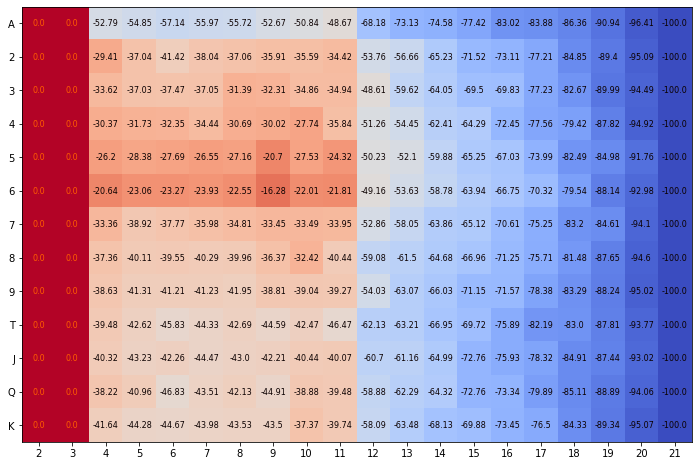

stay


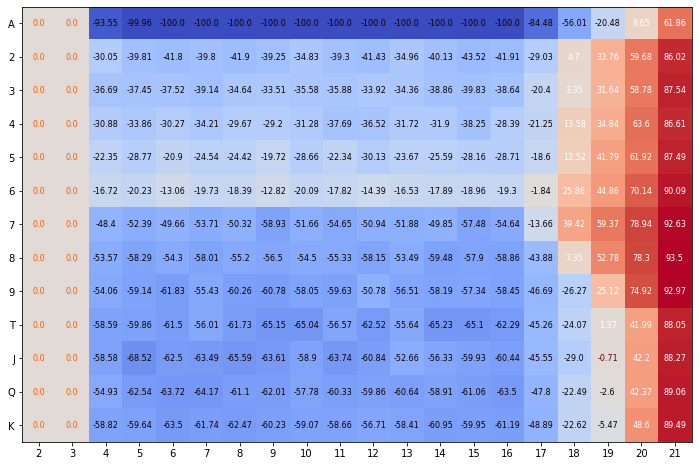

ace=11---------------------
hit


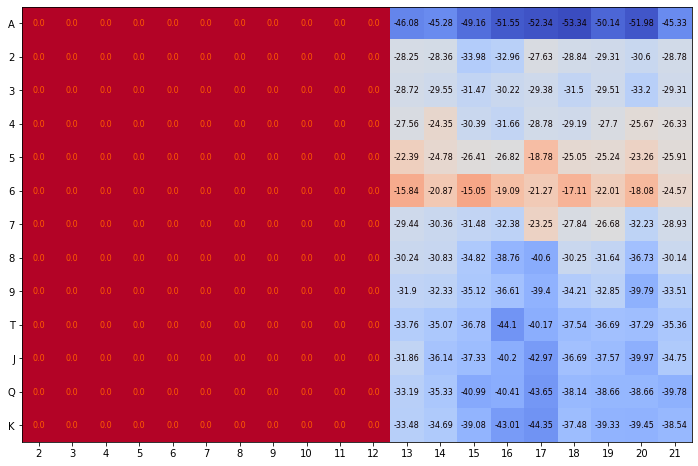

stay


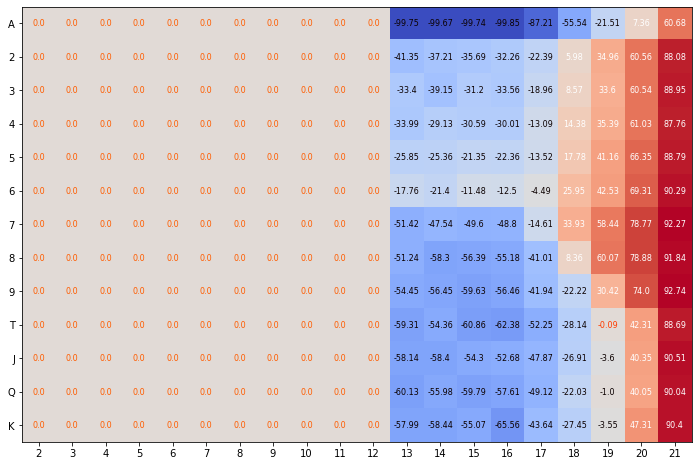

0

In [146]:
Qhit = QTs['h']
Qstay = QTs['s']
print('ace=1--------------------')
print("hit")
Qhit[0].plotGrid()
print("stay")
Qstay[0].plotGrid()

print('ace=11---------------------')
print("hit")
Qhit[1].plotGrid()
print("stay")
Qstay[1].plotGrid()
    


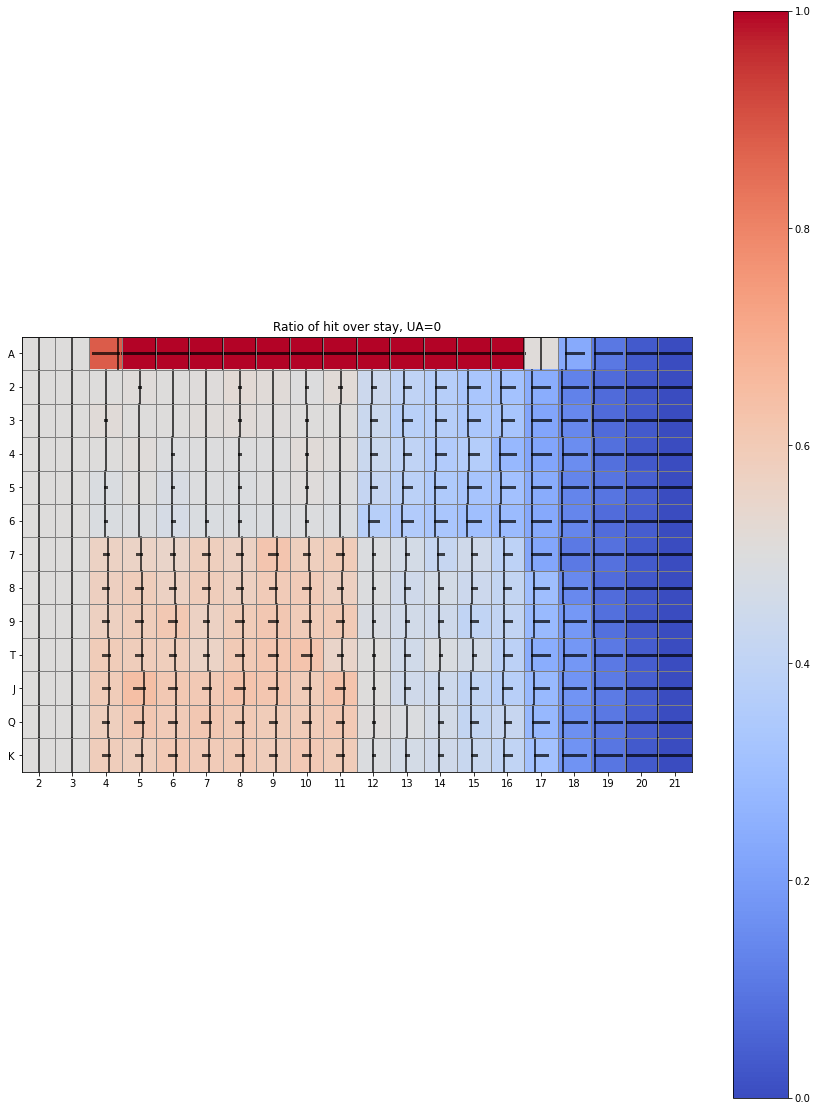

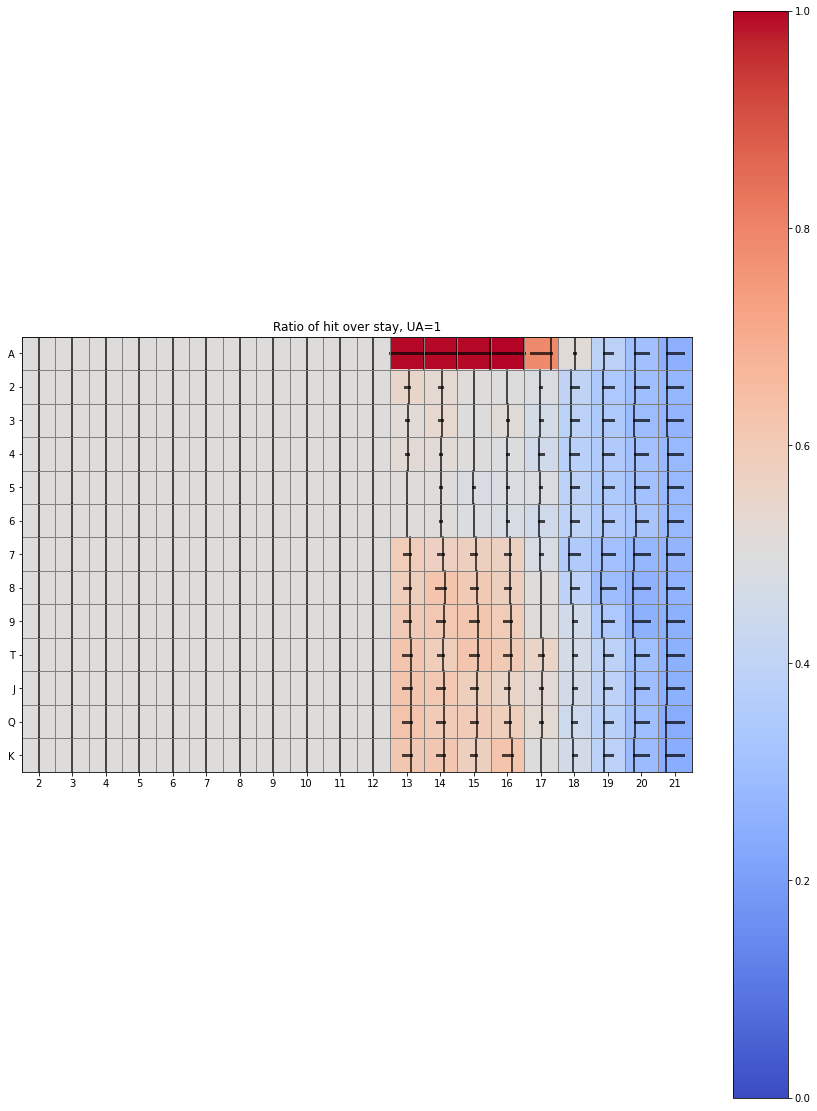

In [147]:
Q_UA0 = [QTs['h'][0].grid, QTs['s'][0].grid]
hit_score = Q_UA0[0]

stay_score = Q_UA0[1]
hit_norm  = (hit_score - (-100))/200
stay_norm = (stay_score - (-100))/200

# print(hit_score[0][0])
# print(hit_norm[0][0])

#hit v.s. stay
ratios = hit_norm/(hit_norm + stay_norm)
# print(ratios)

fig, ax = plt.subplots(figsize=(15,20))
ax.set_xticks(np.arange(len(QTs['h'][0].col_indexes)), labels=QTs['h'][0].col_indexes)
ax.set_yticks(np.arange(len(QTs['h'][0].row_indexes)), labels=QTs['h'][0].row_indexes)
heatmap = ax.imshow(ratios, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=1)

for i in range(ratios.shape[0]):
    for j in range(ratios.shape[1]):
        ratio = ratios[i,j]
        #内部行动分割线
        ax.plot([j-0.5+ratio,j-0.5+ratio], [i-0.5, i+0.5], color='black', alpha=0.9, linewidth = 1.5)
        #方向指导线,长度=2*ratio,起始点在ratio处
        ax.plot([j-0.5+ratio,j+(0.5-ratio)], [i, i], color='black', alpha=0.7, linewidth = 3)
        #边缘线竖线
        ax.plot([j-0.5,j-0.5], [i-0.5, i+0.5], color='grey', linewidth = 1)
        ax.plot([j-0.5,j+0.5], [i-0.5, i-0.5], color='grey', linewidth = 1)

plt.title("Ratio of hit over stay, UA=0")
plt.colorbar(heatmap, ax=ax)


Q_UA1 = [QTs['h'][1].grid, QTs['s'][1].grid]
hit_score = Q_UA1[0]
stay_score = Q_UA1[1]
hit_norm  = (hit_score - (-100))/200
stay_norm = (stay_score - (-100))/200
ratios = hit_norm/(hit_norm + stay_norm)
fig, ax2 = plt.subplots(figsize=(15,20))
ax2.set_xticks(np.arange(len(QTs['h'][0].col_indexes)), labels=QTs['h'][0].col_indexes)
ax2.set_yticks(np.arange(len(QTs['h'][0].row_indexes)), labels=QTs['h'][0].row_indexes)
heatmap2 = ax2.imshow(ratios, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=1)

for i in range(ratios.shape[0]):
    for j in range(ratios.shape[1]):
        ratio = ratios[i,j]
        #内部行动分割线
        ax2.plot([j-0.5+ratio,j-0.5+ratio], [i-0.5, i+0.5], color='black', alpha=0.9, linewidth = 1.5)
        #
        ax2.plot([j-0.5+ratio,j+(0.5-ratio)], [i, i], color='black', alpha=0.7, linewidth = 3)
        #边缘线竖线
        ax2.plot([j-0.5,j-0.5], [i-0.5, i+0.5], color='grey', linewidth = 1)
        ax2.plot([j-0.5,j+0.5], [i-0.5, i-0.5], color='grey', linewidth = 1)

plt.title("Ratio of hit over stay, UA=1")
plt.colorbar(heatmap2, ax=ax2)


In [98]:
#non-constant monte carlo
np.random.rand()

0.6213229694392062

In [138]:
#Gradient Policy
# def GP(M):
#     for m in range(0,M):
#         m_obj = traject('non-greedy', QTs)
class nn_agent:
    def __init__(self, action_space):
        self.action_space = action_space
        #policy现在是一个nn的pdf，输入为(state e.g. (batch_n, 3))，输出为（n_actions*1）的pdf
        #我们在训练的时自定义batch_n,可以是每一个traj update参数一次， 也就是batch_n = 1
        self.net = nn(3, 2)
    
    def policy(self, state):
        pdf = self.pdf(state)
        if np.random.rand() < 0.05:
            print("random choice")
            action = np.random.choice(self.action_space)
        else:
            action = self.action_space[np.argmax(pdf)]
        # print(f"choosing an action {action} based on {pdf}")
        return action
    
    def pdf(self, state):
        s = self.to_numeric_state(state)
        # print(state, s)
        val = self.net.forward(s)
        # print(val)
        return val

    
    def backward_at_t(self, lr, gt, at, st, yeta_t): #preds, gt, at, st, yeta_t, lr
        preds = self.net.forward(self.to_numeric_state(st))
        # print("log pdf:") 
        # print(np.log(preds+0.0000001))
        # print("action one hot:")
        # print(at)
        # print(preds.shape, at.shape)
        # print(at * np.log(preds+0.00001))
        # print(f"gt: {gt}")
        # loss_t = -gt*(at * np.log(preds+0.0001)) #preds - Y => (1,2)
        # print(f"loss at t: {loss_t}")
        # grad_loss = -gt * (at / preds)
        # print(grad_loss)
        self.net.backward(preds, gt, at, st, yeta_t, lr)

    #helper method
    def to_numeric_state(self, state):
        #state mus be numeric............
        #original state in the game is called location: 
        #location = (int(self.game.usefulAce), self.game.dealderFaceUp(), self.game.sum("Player"))
        DF_refer = {'A':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, 'T':10, 'J':11, 'Q':12, 'K':13}
        numeric_state = np.array([int(state[0]), DF_refer[state[1]], state[2]], dtype=np.float32).reshape(1,-1)
        return numeric_state


class nn_traject: 
    def __init__(self, agent, QTable):
        self.agent = agent
        self.session = Session()
        self.DF = None #'A'
        self.winner = None #'Player' 'Dealer' 'Tie'
        self.SATraj = [] #记录的是每一个game tree node在(S,A)空间里的坐标位置 -> rewardt
                        #[l1, r1, l2, r2, l3, r3, ..., ln, rn]

    def currentState(self, node): #a node is a dict from session.gameTree
        PS = node['Player Sum']
        usefulAce = node['Useful Ace']
        self.DF = node['Dealer Face']
        return (usefulAce, self.DF, PS)

    def currentReward(self):
        if self.winner != None:
            if self.winner == "Player":
                return 1 #playe r wins
            elif self.winner == 'Tie':
                return -0.1
            else:
                return -1 #dealer wins
        else:
            return -0.05 #game still on-going
    
    def generateTraject(self): #s1, r1, s2, r2, ...
        #print('------------------------start of the traject----------------------\n')
        self.session.runAgent(self.agent)
        traj = self.session.gameTree
        trajIter = iter(traj)
        next(trajIter) 

        while True:
            currNode = next(trajIter)
            # print(currNode)
            currState = self.currentState(currNode)
            UA = currState[0]
            DF = currState[1]
            PS = currState[2]

            #1.current state is not the ending state (is a legal state), which has the action for next round
            if 'Player Action' in currNode.keys():
                action = currNode['Player Action']
                r = self.currentReward()
            
                self.SATraj.append((UA, DF, PS))
                self.SATraj.append(action)
                self.SATraj.append(r)
            #2.current state is the busted or continued state given by a stay, there will be no action
            #the next node is either 'END' or 'DEALERROUND'
            elif  'Player Action' not in currNode.keys() and 'Result' in currNode.keys():
                result = currNode['Result']
                if result == 'End Round':
                    #不会在这里添加reward
                    #但是要删去上一步的r
                    # assert self.SATraj.pop() == 0
                    self.SATraj.pop()
                    break
                elif result == 'Busted':
                    #会在这里添加reward
                    self.winner = self.session.winner
                    r = self.currentReward()
                    # assert self.SATraj.pop() == 0
                    self.SATraj.pop()
                    self.SATraj.append(r)
                    # print("return is here")
                    return self.SATraj
                else:
                    
                    raise Exception
            #3.DEALERROUND
            else:
                break
        
        #read dealer's turn 这个直接看结果了，因为我们agent的游戏已经结束
        #这个时候，不会去讨论reward state这些东西，没有意义
        # print("read dealer's game tree:")
        while True:
            currNode = next(trajIter)
            #整个游戏结束
            if currNode == 'END':
                self.winner = self.session.winner
                r = self.currentReward()
                self.SATraj.append(r)
                break
            #dealer 还在继续
            #没有任何需要update的地方
        # print("return is here")
        return self.SATraj


class nn_mc:
    def __init__(self, M):
        self.M = M
        self.agent = None

    def start(self):
        QTs = {'h': [Grid(), Grid()], 's':[Grid(), Grid()]} # first grid is UA=0 ,sec grid is UA=1
        action_space = ['h', 's']
        agent = nn_agent(action_space)
        lr = 1/500
        for k in range(M):
            # print(f"seesion-----------------{k}--------------------------------------")
            # print(agent.action_space)
            m = nn_traject(agent, QTs).generateTraject()
            # print(m)
            paired_m = [(m[i], m[i + 1], m[i + 2]) for i in range(0, len(m), 3)] # ( , ,28)
            # print(paired_m)
            for i in range(len(paired_m)):
                # print(f"-step {i}-")
                gt = np.sum([paired_m[j][2]*(0.95)**(j-i) for j in range(i,len(paired_m))])
                at = np.array([float(paired_m[i][1]==a) for a in action_space]) #one-hot for action at t
                st = paired_m[i][0]
                yeta_t = 0.95**(i)
                # print(st)
                # print("backward!")
                agent.backward_at_t(lr, gt, at, st, yeta_t)

        self.agent = agent
    
    def pdf_to_action_table(self): #p(a=hit | s) for every pair of a and s
        g0 = Grid()
        g1 = Grid()
        action_table = [g0, g1] #UA=0 UA=1
        UA = False
        for i in g0.row_indexes:
            for j in g0.col_indexes:
                s = [UA,i,j]
                # print(s)
                # print(self.agent.pdf(s))
                prob_hit = self.agent.pdf(s)[0][0]
                # print(prob_hit)
                g0.updateValue(i,j, prob_hit)

        return action_table

        



# for k in np.arange(0, M):
#     if k% 100000 == 0: print(k)
#     if epsi_greedy == False:
#         m_obj = traject('non-greedy', QTs)
#     else:
#         m_obj = traject('greedy', QTs)

#     m = m_obj.generateTraject() #[(False, 'T', 12), 'h', 0, (False, 'T', 15), 'h', -1]
#     paired_m = [(m[i], m[i + 1], m[i + 2]) for i in range(0, len(m), 3)] # ( , ,28)
#     # print("--------------session---------------------")
#     # print(paired_m)
#     for i in range(0,len(paired_m)):
#         gt = np.sum([paired_m[j][2]*(0.7)**(j-i) for j in range(i,len(paired_m))])
#         # print(gt)
#         hit = paired_m[i][1] #'h'
#         UA = int(paired_m[i][0][0]) #True is 1
#         row = paired_m[i][0][1]
#         col = paired_m[i][0][2]
#         # print(UA, hit, row, col, gt)
#         assert col <= 21
#         q = QTs[hit][UA].getValue(row, col)
#         q_new = q + (1/500)*(gt - q) #gt << q if a=hit
#         # print(q, q_new)
#         QTs[hit][UA].updateValue(row, col, q_new)

#         epsi_greedy = np.random.choice([True, False], p=[1-eps, eps])



class layer:
        def __init__(self, input_shape, output_shape):
            self.length = input_shape
            self.width = output_shape
            self.W = np.random.rand(self.length, self.width)
            self.b = np.zeros((1,output_shape))
            self.input = None
            self.output = None

        def _forward(self, X, af):
            self.input = X
            self.Z = np.dot(X, self.W) + self.b
            if af==True:
                self.A = self.softmax(self.Z)
            else:
                self.A = self.Z
            self.output = self.A
            return self.output
        
        def softmax(self, z):
            temp = 2
            exp_z = np.exp((z-np.max(z))/temp)  # Stability trick
            return exp_z / np.sum(exp_z, axis=1, keepdims=True)
        
        def _backward(self, dA, lr, af):
            # print(self.input.shape, dA.shape)
            #self.input = X => (50, 16)
            #dA = preds - Y => (50, 2)
            #dW => (16, 2)
            # print(f"Current dA is: {dA}")
            m = self.input.shape[0]
            assert m == 1 #now, 1 per batch
            if af==False:
                dZ = dA
                # print(f"prev A's shape {self.input.shape}, dZ's shape{dZ.shape}")
                # print(f"dZ: {dZ}")
                dW = np.dot(self.input.T, dZ) / m #=> (16,1)(1,2) = (16, 2)
                db = np.sum(dA, axis=0, keepdims=True) / m
            else: #used activation function like softmax
                dZ = dA * (self.A*(1-self.A))
                # print(f"prev A's shape {self.input.T.shape}, dZ's shape{dZ.shape}")
                # print(f"dZ: {dZ}")
                dW = np.dot(self.input.T, dZ) / m
                db = np.sum(dA, axis=0, keepdims=True) / m
            # print(dX.shape)
            self.W += lr  * dW
            self.b += lr * db
            # print(f"update W: {self.W} with dW{dW}")

            dA_prev = np.dot(dZ, self.W.T) # (1,2)(2,16) = (1,16)
            return dA_prev #pass to prev layer


class nn:
    def __init__(self, num_features, num_classes, n_layer=3):
        self.l1 = layer(num_features, 32)
        self.l2 = layer(32, 16)
        self.l3 = layer(16, num_classes)
    #all manipulations are on the whole batch
    def forward(self, X):
        # print("forward------")
        # print(f"X: {X}")
        A1 = self.l1._forward(X, af = False)
        # print(f"A1: {A1}")
        A2 = self.l2._forward(A1, af = False)
        # print(f"A2: {A2}")
        A3 = self.l3._forward(A2, af = True)
        # print(f"A3: {A3}")
        return A3

    def loss(self, preds, targets):
        return self.cross_entropy_loss(preds, targets)

    def backward(self, preds, gt, at, st, yeta_t, lr): 
        #我们现在没有明确的target，但是我们给定一个preds的pdf,就可以算出我们当前的损失：
        #对于每个动作a, loss_a = -gt*at*ln(preds)
        # dA3 = preds - targets
        dA3 = -(gt-0.1)*yeta_t*at*(1/(preds+0.001))
        assert dA3.shape[0] == 1 and dA3.shape[1] == 2
        dA2 = self.l3._backward(dA3, lr, True)
        dA1 = self.l2._backward(dA2, lr, False)
        self.l1._backward(dA1, lr, False)

    #helper functions:
    def cross_entropy_loss(self, pred, target):
        # print(pred.shape, target.shape)
        #return [l1, l2, l3, l4, l5, ....]
        return np.sum(np.sum(-(target * np.log(pred+0.000000001)), axis=1))

# X = np.random.rand(50, 10)
# Y = np.array([[int(i[0]==0), int(i[0]==1)] for i in np.random.randint(2, size=[50,1])])

# def train(eps, X, Y):
#     model = nn(10, 2)

#     losses = []
#     for ep in range(eps):
#         preds = model.forward(X)
#         loss = model.loss(preds, Y)
#         losses.append(loss)
#         model.backward(preds, Y)
#     print(np.array(range(eps)), np.array(losses))
#     plt.plot(np.array(range(eps)), np.array(losses))
#     return model

# m1 = train(10, X, Y)



In [ ]:
# QTs = {'h': [Grid(), Grid()], 's':[Grid(), Grid()]} # first grid is UA=0 ,sec grid is UA=1
# action_space = ['h', 's']
# agent = nn_agent(action_space)
# m = nn_traject(agent, QTs).generateTraject()
# lr = 1/100

# paired_m = [(m[i], m[i + 1], m[i + 2]) for i in range(0, len(m), 3)] # ( , ,28)
# print(paired_m)
# for i in range(0, len(paired_m)):
#     print(f"--------------session {i}-----------------")
#     print()
#     gt = np.sum([paired_m[j][-1]*(0.95)**(j-i+1) for j in range(i,len(paired_m))])
#     print(gt)
#     at = np.array([float(paired_m[i][1]==a) for a in action_space]) #one-hot for action at t
#     st = paired_m[i][0]
#     print(f"gt:{gt}, at: {at}")
#     agent.backward_at_t(lr, gt, at, st)




del M
del sim

M = 100000
sim = nn_mc(M)
sim.start()

AT_hit = sim.pdf_to_action_table()
# print(AT_hit[0].grid)
AT_hit[0].plotGrid()


In [ ]:
# TD for Black Jack 
class try:
    def __init__(self):
        self.game = Game()
        self.s0 = (self.game.usefulAce, self.game.DH[0].show, self.game.)
game = Game()
def next(state, action):
    if action == 'h':
        game.newHand("Player")
        PS = game.sum("Player")
        DS = game.DH[0].show
        UA = game.UsefulAce

        s1 = (UA, DS, PS)
        busted = game.Busted("Player")
        if busted:
            done = True
            r = -1
        else:
            done = False
            r = 0
        return s1, r
    else:
        s1 = s0
        DealerTurn(game)
        if game.winner == "Dealer":
            r = -1
        else:
            r = 1
        return s1, r
        
    


In [212]:
#Value Iteration - Q-Learning based on TD
import gym
import numpy as np
import time, pickle, os
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

In [213]:
eps = 0.95
epochs = 1000
max_steps = 100

lr = 0.75
gamma = 0.9
Q = np.zeros((env.observation_space.n, env.action_space.n))
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(16)


In [214]:
def select_action(state): #states is a number
    if np.random.uniform(0, 1) < eps:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :]) #or .index(state)
    print(action)
    return action

def learn(s0, s1, r, a):
    Q0_pred = Q[s0, a]
    Q0_actual = r + gamma*np.max(Q[s1,:])
    print(Q0_pred, Q0_actual, r)
    Q[s0, a] += lr*(Q0_actual-Q0_pred)

for ep in range(epochs):
    print(ep)
    s = env.reset()[0] #or call a new session()
    print(s)
    t=0
    while t<max_steps:
        env.render() #prepare
        a = select_action(s)
        s1, r, done, info, _ = env.step(a)
        learn(s, s1, r, a)
        s = s1
        t += 1
        if done:
            break
        time.sleep(0.1)
    
print(Q)
with open("QTable_FrozenLake.pkl", 'wb') as f:
    pickle.dump(Q, f)


0
0
0
0.0 0.0 0.0
3
0.0 0.0 0.0
1
0
0
0.0 0.0 0.0


/opt/anaconda3/lib/python3.9/site-packages/gym/envs/toy_text/frozen_lake.py:271: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("FrozenLake-v1", render_mode="rgb_array")
  logger.warn(
/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


2
0.0 0.0 0.0
0
0.0 0.0 0.0
2
0.0 0.0 0.0
1
0.0 0.0 0.0
2
0
3
0.0 0.0 0.0
1
0.0 0.0 0.0
1
0.0 0.0 0.0
3
0.0 0.0 0.0
3
0.0 0.0 0.0
3
0.0 0.0 0.0
0
0.0 0.0 0.0
3
0.0 0.0 0.0
2
0.0 0.0 0.0
2
0.0 0.0 0.0
3
0
2
0.0 0.0 0.0
0
0.0 0.0 0.0
1
0.0 0.0 0.0
1
0.0 0.0 0.0
2
0.0 0.0 0.0
3
0.0 0.0 0.0
0
0.0 0.0 0.0
1
0.0 0.0 0.0
3
0.0 0.0 0.0
4
0
0
0.0 0.0 0.0
0
0.0 0.0 0.0
3
0.0 0.0 0.0
2
0.0 0.0 0.0
3
0.0 0.0 0.0
3
0.0 0.0 0.0
1
0.0 0.0 0.0
2
0.0 0.0 0.0
1
0.0 0.0 0.0
1
0.0 0.0 0.0
2
0.0 0.0 0.0
2
0.0 0.0 0.0
1
0.0 0.0 0.0
2
0.0 0.0 0.0
5
0
1
0.0 0.0 0.0
3
0.0 0.0 0.0
6
0
2
0.0 0.0 0.0
3
0.0 0.0 0.0
1
0.0 0.0 0.0
2
0.0 0.0 0.0
0
0.0 0.0 0.0
7
0
3
0.0 0.0 0.0
0
0.0 0.0 0.0
8
0
0
0.0 0.0 0.0
0
0.0 0.0 0.0
2
0.0 0.0 0.0
3
0.0 0.0 0.0
9
0
0
0.0 0.0 0.0
2
0.0 0.0 0.0
0
0.0 0.0 0.0
2
0.0 0.0 0.0
0
0.0 0.0 0.0
2
0.0 0.0 0.0
3
0.0 0.0 0.0
1
0.0 0.0 0.0
3
0.0 0.0 0.0
10
0
3
0.0 0.0 0.0
1
0.0 0.0 0.0
1
0.0 0.0 0.0
2
0.0 0.0 0.0
0
0.0 0.0 0.0
2
0.0 0.0 0.0
3
0.0 0.0 0.0
3
0.0 0.0 0.0
0
0.0 0.0 0.0
0
0.0 0.0 0

In [218]:
np.round(pd.read_pickle('QTable_FrozenLake.pkl'), decimals=3)

array([[0.242, 0.266, 0.268, 0.27 ],
       [0.241, 0.209, 0.068, 0.309],
       [0.28 , 0.291, 0.345, 0.27 ],
       [0.309, 0.075, 0.089, 0.295],
       [0.296, 0.067, 0.358, 0.053],
       [0.   , 0.   , 0.   , 0.   ],
       [0.316, 0.   , 0.41 , 0.239],
       [0.   , 0.   , 0.   , 0.   ],
       [0.317, 0.382, 0.298, 0.422],
       [0.425, 0.407, 0.483, 0.099],
       [0.472, 0.141, 0.21 , 0.117],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.034, 0.367, 0.44 , 0.114],
       [0.789, 0.595, 0.941, 0.999],
       [0.   , 0.   , 0.   , 0.   ]])

In [148]:
np.log(1) #100%选择的情况下，loss就为0 y(st) == [0 1] => [1 0]*[0 1] = [0 0] =>log(0) = -inf
#纠正 np.array([1,0]) * np.log([0.2, 0.5])
np.array([0,1]) * np.log([0.0000001, 0.9999])

array([-0.        , -0.00010001])

In [ ]:

# data = [
#     {'active_inventory': 10000, 'age': 0},
#     {'active_inventory': 8750, 'age': 1},
#     {'active_inventory': 7500, 'age': 2},
#     {'active_inventory': 6250, 'age': 3},
#     {'active_inventory': 5000, 'age': 4},
#     {'active_inventory': 5000, 'age': 5},
#     {'active_inventory': 3750, 'age': 6},
#     {'active_inventory': 3750, 'age': 7},
#     {'active_inventory': 3750, 'age': 8},
#     {'active_inventory': 2500, 'age': 9},
#     {'active_inventory': 2500, 'age': 10},
#     {'active_inventory': 2500, 'age': 11},
#     {'active_inventory': 1250, 'age': 12},
#     {'active_inventory': 1250, 'age': 13},
#     {'active_inventory': 1250, 'age': 14},
#     {'active_inventory': 0, 'age': -1},
#     {'active_inventory': 0, 'age': -1},
#     {'active_inventory': 10000, 'age': 0},
#     {'active_inventory': 10000, 'age': 1},
#     {'active_inventory': 10000, 'age': 2},
#     {'active_inventory': 8750, 'age': 3},
# ]

exp_threshold = 24

def compute_reorder_cycle(data):
    reorder_times = []
    for i in range(1, len(data)):
        #if current inventory is greater than last period's inventory, then a reorder happens
        if data[i]['active_inventory'] > data[i - 1]['active_inventory']:
            reorder_times.append(i)
    #time differences between each reorder events
    reorder_durations = [reorder_times[i] - reorder_times[i - 1] for i in range(1, len(reorder_times))]
    avg_reorder_cycle = sum(reorder_durations) / len(reorder_durations) if reorder_durations else 0
    return avg_reorder_cycle

def compute_expired_inventory(data):
    total_expired = 0
    total_periods = len(data)
    for entry in data:
        #if current inventory's age is greater than the exiration threshold (24 weeks for 6 months), then an expriration happens
        if entry['age'] > exp_threshold:
            total_expired += entry['active_inventory']

    avg_expired_inventory = total_expired / total_periods
    return avg_expired_inventory

avg_reorder_cycle = compute_reorder_cycle(data)
avg_expired_inventory = compute_expired_inventory(data)

print(avg_reorder_cycle, avg_expired_inventory)


(0, 0.0)

In [7]:
#11-09 -> 11-30 (8709.53)
18137.10 - 20.08+23.80+145.13+321.36+148.44+211.99+37.59+65.52+82.70+548.44+215.98+410.15+72.93+51.02+838.68+187.62+263
#11-01 -> 11-06
print(68.69+89.72+75.06+77.20+191.42+399.45+644.32+247.22+89.85+1341.66+191.06+206.76+178.40+200.43+21.55+62.09+195.38+166.87+75.84+38.32+45.91)

4607.2


In [ ]:
a=8709.53 + 4607.2 #招商
b=672.79 #中信
car = 3818.64 #外部
a + b + car

17808.16

In [6]:
45.91/7.1

6.466197183098592

In [ ]:
7.15+4.65+33.15+16.40+110.75+54.29+7.65+7.15+3.65+4.15

248.99